# 操作变量优化
**产品硫含量**：由于问题三并没有提到产品硫含量，而问题四中要求产品硫含量要低于5，因此需要找到合适的模型对产品硫含量进行预测

In [12]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import pickle
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
## 导入问题三训练好的SVR模型参数
with open('SVR_model.pkl','rb') as f :
    svr_RON = pickle.load(f)

In [13]:
## 导入产品硫含量以及自变量矩阵
p4_df = pd.read_csv('p3data.csv',encoding='GBK')
y_S = p4_df['产品硫含量']
y_RON = p4_df['产品辛烷值']
p4_data = p4_df.values

y_RON = np.array(y_RON)
y_S_min = np.min(p4_data[:,-1]) ##用于数据还原
y_S_max = np.max(p4_data[:,-1]) ##同上


# y_RON_max = np.max(p4_data[:,-2])
# y_RON_min = np.min(p4_data[:,-2])
## 对数据进行归一化
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# 初始化归一化器
scaler = MinMaxScaler()
# scaler = StandardScaler()
# 对数据进行归一化处理
data = scaler.fit_transform(p4_data)
X = data[:,:-2]  ##用于SVR训练的数据（此时以及归一化）
y = data[:,-1]  ## 同上
# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## XGboost对产品硫含量进行预测


R-squared:
 0.4801097883244714
MSE:
 1.3521255404882078
MAE:
 0.7437134896791898
RMSE:
 1.1628093310978407


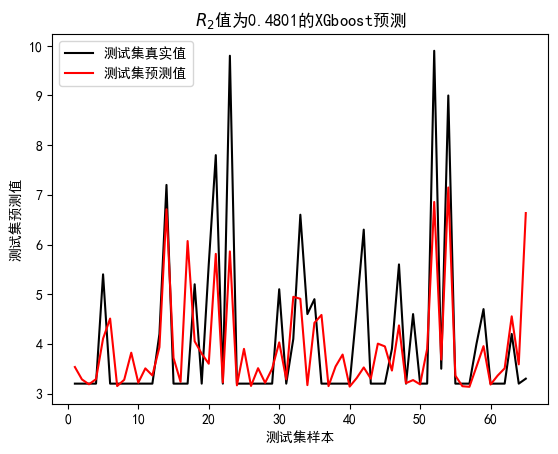

In [14]:
import xgboost as xgb
# 将训练数据封装为DMatrix格式
xg_model = xgb.XGBRegressor(learning_rate = 0.1,max_depth =8,n_estimators = 1000)
xg_model.fit(X_train,y_train)
# 将训练好的模型保存到磁盘上
xg_model.save_model('xg_model.bin')

# 进行预测
y_pred = xg_model.predict(X_test)

## 将测试集预测的数据与原始数据进行画图展示
x_vector = list(i for i in range(1,y_pred.shape[0]+1))
y_true = y_test*(y_S_max-y_S_min)+y_S_min
y_pre = y_pred*(y_S_max-y_S_min)+y_S_min
## 决定系数：R2 评估预测模型拟合程度的一种指标，它表示预测值与真实值的协方差占真实值方差的比例。$R^2$越接近1，说明预测结果越接近真实值
r2 = r2_score(y_true ,y_pre)  

## 均方误差
mse = mean_squared_error(y_true,y_pre) # MSE是预测值与真实值之差的平方的平均值。MSE越小，说明预测结果与真实值越接近

## 平均绝对误差
mae = mean_absolute_error(y_true,y_pre) #MAE是预测值与真实值之差的绝对值的平均值。MAE越小，说明预测结果与真实值越接近
# 均方根误差（RMSE）
rmse = np.sqrt(mse)

print('R-squared:\n', r2)  # 0.9542180965997185
print('MSE:\n',mse)
print('MAE:\n',mae)
print("RMSE:\n", rmse)
## 作图
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(x_vector,y_true,'k-')
plt.plot(x_vector,y_pre,'r-')
plt.xlabel('测试集样本')
plt.ylabel('测试集预测值')
plt.title('$R_2$值为{:.4f}的XGboost预测'.format(round(r2,4)))
plt.legend(['测试集真实值','测试集预测值'])
import os 
if not os.path.exists("Images"):
    os.mkdir("Images")
plt.savefig('Images/XGboost_predict_S.png')
plt.show()

**综上所述**：我们最后选择XGboost算法对产品硫含量进行预测
## 下面使用遗传算法对变量进行优化

In [15]:
fixed_cols = ['待生吸附S','待生吸附-焦碳','原料饱和烃','原料硫含量','原料密度','原料辛烷值']

fixed_values = p4_df[fixed_cols]

fixed_vars = fixed_values.values   ## 原料、待生吸附剂、再生吸附剂的变量值不变

var_names = ['蒸汽进装置流量', '稳定塔下部温度', '蒸汽进装置压力', '燃料气进装置流量', '原料进装置流量', '精制汽油出装置流量',
       '反应器底部温度', '循环水出装置流量', 'D105流化氢气流量', '净化风进装置流量', '原料泵出口流量', '稳定塔液位',
       '反应器上部温度', '净化风进装置压力', '氮气进装置压力', 'D107提升氮气流量', '精制汽油出装置硫含量', '轻烃出装置流量',
       '3#催化汽油进装置流量', '循环水进装置流量', '0.3MPa凝结水出装置流量', '燃料气进装置压力', '氮气进装置流量',
       '污油出装置']
x_RON = p4_df['原料辛烷值']
x_RON = np.array(x_RON)
lB = [] ##操作变量的下界
UB = [] ##操作变量的上界

end_vars = []
var_df = pd.read_csv('操作变量取值.csv',encoding='GBK')

raws = var_df.values.shape[0]
for j in range(raws):
    if var_df.values[j][0] in var_names:
        end_vars.append(var_df.values[j][0])
        lB.append(var_df.values[j][1])
        UB.append(var_df.values[j][2])
lb1 = np.tile(lB,(fixed_vars.shape[0],1)) ##操作变量的下界
ub1 = np.tile(UB,(fixed_vars.shape[0],1)) ##操作变量的上界
lb = lb1.reshape(-1, len(lB))
ub = ub1.reshape(-1, len(UB))
X_min = np.hstack((fixed_vars,lb))  ##所有变量的最小值
X_max = np.hstack((fixed_vars,ub))  ##所有变量的最大值


# 实数制编码进行遗传算法求解

In [77]:
## 编写遗传算法进行求解
import random
random.seed(100)
iters = 1000##迭代次数
pop_size = 200  ##种群数量
mutation_rate = 0.01 ##变异率
crossover_rate = 0.9 ##交叉率
var_size = 30  ##变量个数，在遗传算法中称为染色体长度，本例中采用实数编码
pop = []  ##初始化种群为空列表
y_RON_max = np.max(y_RON)
y_RON_min = np.min(y_RON)
## 定义函数，在本例中是经过SVR算法进行预测的结果
def svr(population):
    scaler = MinMaxScaler()
    x_arr = np.array(population)
    x = scaler.fit_transform(x_arr)
    RON = svr_RON.predict(x)
    S   = xg_model.predict(x)
    RON_pre = RON*(y_RON_max-y_RON_min)+y_RON_min
    S_pre  = S*(y_S_max-y_S_min)+y_S_min
    return RON_pre,S_pre   ##返回预测值
    
# 编写初始化种群函数
def init_population(index):
    populatin = []
    for i in range(pop_size):
        pop_i = []  ##初始化种群中第i个个体的值为空列表
        for j in range(var_size):
            if j in [0,1,2,3,4,5]: 
                pop_i.append(X_min[index,j]) ##前六个变量是固定不变的
            else:
                pop_i.append(random.uniform(X_min[index,j],X_max[index,j]))  ##剩余24个变量随机的选取最小值和最大值之间的值
        ## 经过上述循环得到了第i个个体的所有染色体片段
        populatin.append(pop_i)  ##添加第i个个体，一共组成population这样的列表

    return populatin

## 编写适应度函数

def fitness_value(population,index): 
    
    RON_pre,S_pre = svr(population=population)
    RON_true = y_RON[index] ##优化前的产品辛烷值
    RON_old  = x_RON[index] ##优化前的原料辛烷值
    fitness_val = []
    for i in range(len(population)):
        if S_pre[i] >5 or S_pre[i]<0 or RON_pre[i]>RON_old or RON_pre[i]<0 :##如果产品硫含量的预测值大于5或者小于0或者预测的产品辛烷值大于原料辛烷值的话，就将适应度函数值赋值一个很小的值
            fitness_val.append(1e-6)
        else:
            fitness_val.append(RON_pre[i]-np.min(RON_pre)+1e-3)  # 减去最小的适应度是为了防止适应度出现负数,加入1e-3是为了防止适应度函数出现0的情况
    return fitness_val


## 编写选择染色体函数
def select_pop(population,fitness_value):
    pop = np.array(population)
    idx = np.random.choice(np.arange(pop_size), size=pop_size, replace=True,
                           p=(np.array(fitness_value))/((np.array(fitness_value)).sum()) )
    new_p = list(pop[idx])
    return new_p


# 编写交叉变异染色体函数
def crossover_mutation(population,index):
    new_pop = []
    for father in population:
        child = father
        if np.random.rand()<crossover_rate:
            mother = population[np.random.randint(pop_size)]  ##随机选择一个个体作为母亲
            cross_point = np.random.randint(low=0,high=var_size)  ##随机选择交叉点
            child[cross_point] = mother[cross_point]  ##将交叉点以后得基因片段进行交叉
        mutate_pop(child,index)  ##每个后代都有一定的概率发生变异
        new_pop.append(child)
    return new_pop


# 编写变异染色体函数
def mutate_pop(child,index):
    for i in range(len(child)):
        if np.random.rand()<mutation_rate and  i not in [0,1,2,3,4,5]:
            child[i] = random.uniform(X_min[index,i],X_max[index,i])
        

# 编写主程序

def Genetic_run(ind):
    pop = init_population(index=ind)  ##第一代
    for iter in range(iters):
        fit_val = fitness_value(population=pop,index=ind)  ##计算适应度函数值
        select_population = select_pop(population=pop,fitness_value=fit_val) ##选择
        pop = crossover_mutation(population=select_population,index=ind)  ##交叉与变异
    
    fitness_val = fitness_value(population=pop,index=ind)  ##在经过选择交叉变异之后重新进行适应度函数计算
    best_index = fitness_val.index(max(fitness_val))   ##找到最大的适应度函数值
    
    return pop[best_index],max(fitness_val) 

best_x = []
best_y = []
num = 1
for i in range(325):
    x,y = Genetic_run(i)
    best_x.append(x)
    print("第{}个样本处理完毕".format(str(i+1)))
    num = num+1


第1个样本处理完毕
第2个样本处理完毕
第3个样本处理完毕
第4个样本处理完毕
第5个样本处理完毕
第6个样本处理完毕
第7个样本处理完毕
第8个样本处理完毕
第9个样本处理完毕
第10个样本处理完毕
第11个样本处理完毕
第12个样本处理完毕
第13个样本处理完毕
第14个样本处理完毕
第15个样本处理完毕
第16个样本处理完毕
第17个样本处理完毕
第18个样本处理完毕
第19个样本处理完毕
第20个样本处理完毕
第21个样本处理完毕
第22个样本处理完毕
第23个样本处理完毕
第24个样本处理完毕
第25个样本处理完毕
第26个样本处理完毕
第27个样本处理完毕
第28个样本处理完毕
第29个样本处理完毕
第30个样本处理完毕
第31个样本处理完毕
第32个样本处理完毕
第33个样本处理完毕
第34个样本处理完毕
第35个样本处理完毕
第36个样本处理完毕
第37个样本处理完毕
第38个样本处理完毕
第39个样本处理完毕
第40个样本处理完毕
第41个样本处理完毕
第42个样本处理完毕
第43个样本处理完毕
第44个样本处理完毕
第45个样本处理完毕
第46个样本处理完毕
第47个样本处理完毕
第48个样本处理完毕
第49个样本处理完毕
第50个样本处理完毕
第51个样本处理完毕
第52个样本处理完毕
第53个样本处理完毕
第54个样本处理完毕
第55个样本处理完毕
第56个样本处理完毕
第57个样本处理完毕
第58个样本处理完毕
第59个样本处理完毕
第60个样本处理完毕
第61个样本处理完毕
第62个样本处理完毕
第63个样本处理完毕
第64个样本处理完毕
第65个样本处理完毕
第66个样本处理完毕
第67个样本处理完毕
第68个样本处理完毕
第69个样本处理完毕
第70个样本处理完毕
第71个样本处理完毕
第72个样本处理完毕
第73个样本处理完毕
第74个样本处理完毕
第75个样本处理完毕
第76个样本处理完毕
第77个样本处理完毕
第78个样本处理完毕
第79个样本处理完毕
第80个样本处理完毕
第81个样本处理完毕
第82个样本处理完毕
第83个样本处理完毕
第84个样本处理完毕
第85个样本处理完毕
第86个样本处理完毕
第87个样本处理完毕
第88个样本处理完毕
第89个样本处理完毕
第90个样本处理完毕
第91个样本处理完毕
第92个样本处理

In [78]:
# print(svr_RON.predict(scaler.fit_transform(best_x)))
RON_pre = svr_RON.predict(scaler.fit_transform(best_x))
S_pre = xg_model.predict(scaler.fit_transform(best_x))
ron_pre = RON_pre*(y_RON_max-y_RON_min)+y_RON_min
s_pre = S_pre*(y_S_max-y_S_min)+y_S_min
# print(ron_pre)
print(s_pre)

[5.1546082 5.9391446 6.477394  5.6008425 4.127241  4.7800646 5.2668858
 6.82056   4.695279  4.3148394 3.9554505 4.441445  4.027501  3.7351851
 4.3351507 4.1726456 5.690438  4.8362923 4.295213  5.573331  4.2726192
 6.5688705 4.8136673 5.4611006 6.659296  4.262197  4.3473344 5.9994993
 5.363077  5.9326553 4.544607  4.064556  4.052688  3.8540673 5.2985926
 4.641657  4.071166  4.105474  5.146268  5.2093496 5.843199  3.940114
 6.550682  4.413771  4.974591  6.701565  6.190831  4.9236345 4.6441936
 4.427112  5.512184  3.9972248 5.548999  3.7891746 6.0936623 6.048009
 6.083382  6.0313196 5.014325  5.4133396 5.51138   4.657523  6.295064
 5.841675  6.1446486 6.3140016 3.7693815 4.345027  4.2636538 6.40064
 4.13419   6.3590117 4.1599555 5.2106566 6.2637043 3.8959568 5.9532185
 5.0704064 5.8306627 6.2728424 5.5294437 5.4020796 5.491315  4.6894813
 5.5854435 4.1926775 4.7781744 6.6102934 5.4076705 7.5987425 6.563511
 5.310859  5.837208  8.209226  7.1350307 7.3076067 5.3855534 6.425886
 7.201112  6.

In [79]:
loss0 = x_RON - y_RON  ##优化前的损失
loss1 = x_RON -ron_pre       ##优化后的损失
percent = (loss0-loss1)/loss0  ##优化后的损失降幅
best_loss = []
index = []
for i in range(len(loss0)):
    ## 如果优化后的样本产品辛烷值损失值降幅大于30％并且还要满足优化的产品辛烷值不能高于原料辛烷值，同时产品的硫含量也不能高于5
    if percent[i]>=0.3  and loss1[i]>0 and s_pre[i]<5:
        best_loss.append(percent[i]) ##记录最优的降幅比
        index.append(i) ##记录最优的索引
print(best_loss)
print(index,len(index))

[0.8459058061746175, 0.6323360471516373, 0.6727753022011109, 0.37538300091336535, 0.9717370966478925, 0.7182627324469738, 0.37982608602340545, 0.5414219803327007, 0.7273891488464734, 0.5568996408145498, 0.9768905890192721, 0.40737012895595986, 0.5991729525586752, 0.3117119019166256, 0.5972687002772474, 0.3773324870825472, 0.539527930324333, 0.3453955462540561, 0.60049989701199]
[4, 13, 18, 41, 47, 51, 53, 70, 86, 121, 135, 148, 160, 180, 205, 227, 228, 229, 251] 19


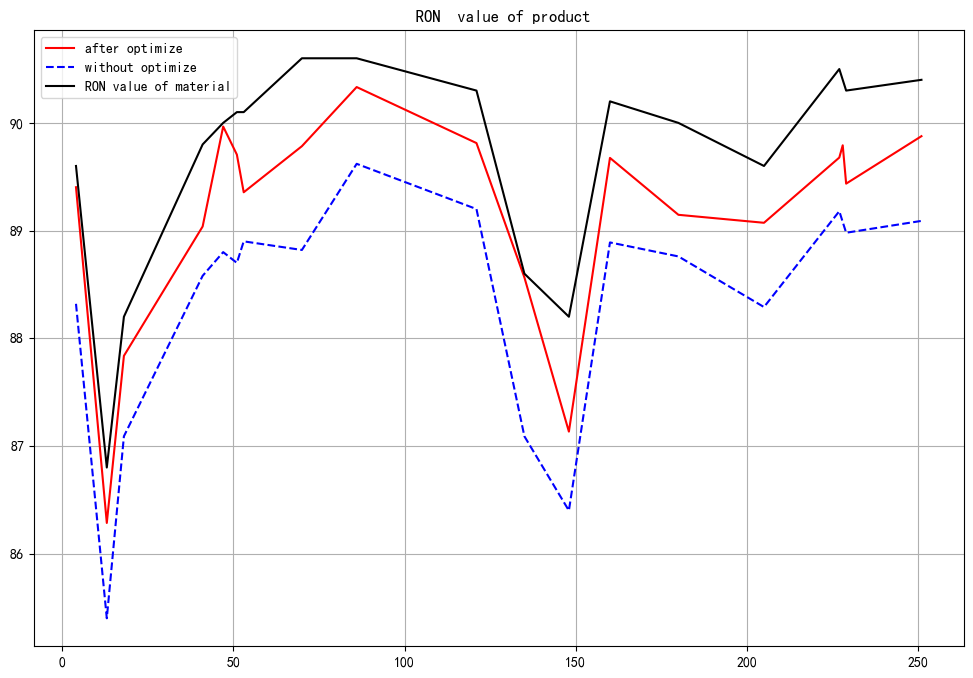

In [80]:
y_old = y_RON[index]
y_best = ron_pre[index]
material_RON = x_RON[index]
## 绘制折线图
plt.figure(figsize=(12, 8), dpi=100)
plt.grid(open)
plt.plot(index,y_best,'r',label = 'after optimize')
plt.plot(index,y_old,'b--',label = 'without optimize')
plt.plot(index,material_RON,'k',label = 'RON value of material')
plt.title('  RON  value of product ')
plt.legend()
if not os.path.exists("Images"):
    os.mkdir("Images")
plt.savefig('Images/varations_optimize.png')
plt.show()